# PREDECIR EL TAMAÑO DEL TUMOR

In [1]:
# Load libraries
import pandas as pd #Pandas es una biblioteca de manipulación y análisis de datos en Python.
from sklearn.tree import DecisionTreeClassifier # Esta clase se utiliza para construir modelos de árboles de decisión.
from sklearn.model_selection import train_test_split # Dividir conjuntos de datos en conjuntos de entrenamiento y prueba,
from sklearn import metrics #funciones para evaluar el rendimiento de modelos(en este caso precisión)
import matplotlib.pyplot as plt#para crear gráficos y visualizaciones
import seaborn as sns #biblioteca de visualización que trabaja junto con Matplotlib para proporcionar estilos y funciones adicionales.
from sklearn.preprocessing import OneHotEncoder#que se utiliza para realizar codificación one-hot en variables categóricas
from sklearn.ensemble import BaggingClassifier# Para utilizar bagging
from graphviz import Source#Graphviz es una herramienta para visualización de grafos y, en este contexto, se puede utilizar para visualizar gráficamente estructuras de árboles de decisión
from sklearn.tree import export_graphviz#Exportar la estructura de un árbol de decisión en un formato que puede ser visualizado por Graphviz.
import os #interfaz para interactuar con el sistema operativo. Se usa aquí para manipular rutas de archivos.
from IPython.display import Image#Se utiliza para mostrar imágenes en un entorno de Jupyter Notebook.
from subprocess import call#Llamar a comandos del sistema desde Python, como en el caso de convertir un archivo DOT a una imagen PNG usando Graphviz.
from sklearn.model_selection import cross_val_score, KFold # Para la validación cruzada
import numpy as np# para los arrays
from sklearn.model_selection import GridSearchCV# para hacer la busqueda en la validación cruzada
from sklearn.model_selection import StratifiedKFold, cross_val_score# Para la validación cruzada estratificada
from sklearn.ensemble import RandomForestClassifier# Para traer el metodo random forest
from sklearn.ensemble import GradientBoostingClassifier# Boosting

In [2]:
col_names = ['Class','Age','Menopause','Tumor-size','Inv-nodes','Node-caps','Deg-malig','Breast','Breast-quad','Irradiat']
# load dataset
DATABASE1= pd.read_csv("breast-cancer.csv", header=0, names=col_names)
DATABASE1.info()
DATABASE1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   Age          286 non-null    object
 2   Menopause    286 non-null    object
 3   Tumor-size   286 non-null    object
 4   Inv-nodes    286 non-null    object
 5   Node-caps    286 non-null    object
 6   Deg-malig    286 non-null    int64 
 7   Breast       286 non-null    object
 8   Breast-quad  286 non-null    object
 9   Irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 24.6+ KB


,Class,Age,Menopause,Tumor-size,Inv-nodes,Node-caps,Deg-malig,Breast,Breast-quad,Irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


In [3]:
import pandas as pd

# Supongamos que ya tenemos DATABASE1 definido

# DATABASE2 será nuestra nueva base de datos 
DATABASE2 = pd.DataFrame()
for column in DATABASE1.columns:
    if DATABASE1[column].dtype == 'object' and column.lower() != 'deg_malig':
        DATABASE2[column + '_numerico'], _ = DATABASE1[column].factorize()
    else:
        DATABASE2[column + '_numerico'] = DATABASE1[column]

# Mostrar DATABASE2
print("DATABASE2:")
print(DATABASE2)

# Imprimir relaciones entre categorías originales y números asignados
for column in DATABASE2.columns:
    print(f"\nRelación entre categorías originales y números asignados en {column}:")
    if '_numerico' in column:
        if column.lower() == 'deg_malig_numerico':
            # Obtener el orden original de las categorías
            categorias_ordenadas = DATABASE1[column.replace('_numerico', '')].unique()
            for categoria in categorias_ordenadas:
                frecuencia = DATABASE2[column].value_counts()[categoria]
                print(f"{categoria}: {categoria} (Frecuencia: {frecuencia})")
        else:
            for categoria, frecuencia in DATABASE2[column].value_counts().items():
                categoria_original = DATABASE1.loc[DATABASE2[column] == categoria, column.replace('_numerico', '')].iloc[0]
                print(f"{categoria}: {categoria_original} (Frecuencia: {frecuencia})")


DATABASE2:
     Class_numerico  Age_numerico  Menopause_numerico  Tumor-size_numerico  \
0                 0             0                   0                    0   
1                 0             1                   0                    1   
2                 0             1                   0                    1   
3                 0             2                   1                    2   
4                 0             1                   0                    3   
..              ...           ...                 ...                  ...   
281               1             0                   0                    0   
282               1             0                   0                    1   
283               1             2                   1                    1   
284               1             1                   1                    0   
285               1             3                   1                    0   

     Inv-nodes_numerico  Node-caps_numerico  Deg-mal

In [4]:
features=['Class_numerico','Deg-malig_numerico','Age_numerico','Menopause_numerico','Inv-nodes_numerico','Node-caps_numerico','Breast_numerico','Breast-quad_numerico','Irradiat_numerico'] # Features
y = DATABASE2['Tumor-size_numerico'] # Target variable
X=DATABASE2[features]
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.3,
                                                    random_state=1) # 70% training and 30% test


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define los valores que deseas probar para cada hiperparámetro
n_estimators_values = [50, 100, 150]
max_depth_values = [None, 5, 10]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

best_accuracy = 0
best_params = {}

# Itera sobre todas las combinaciones de hiperparámetros
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            for min_samples_leaf in min_samples_leaf_values:
                # Define el clasificador con los hiperparámetros actuales
                clf = RandomForestClassifier(n_estimators=n_estimators, 
                                             max_depth=max_depth, 
                                             min_samples_split=min_samples_split, 
                                             min_samples_leaf=min_samples_leaf,
                                             random_state=3,bootstrap=True)
                # Entrena el clasificador
                clf.fit(X_train, y_train)
                
                # Evalúa el rendimiento en los datos de entrenamiento
                y_pred = clf.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                
                # Actualiza el mejor rendimiento y los mejores hiperparámetros si es necesario
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'n_estimators': n_estimators, 
                                   'max_depth': max_depth, 
                                   'min_samples_split': min_samples_split, 
                                   'min_samples_leaf': min_samples_leaf}

print("Mejores hiperparámetros:", best_params)
print("Mejor precisión con Bootstrap:", best_accuracy)


Mejores hiperparámetros: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}
Mejor precisión con Bootstrap: 0.313953488372093


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define los valores que deseas probar para cada hiperparámetro
n_estimators_values = [50, 100, 150]
max_depth_values = [None, 5, 10]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

best_accuracy = 0
best_params = {}

# Itera sobre todas las combinaciones de hiperparámetros
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            for min_samples_leaf in min_samples_leaf_values:
                # Define el clasificador con los hiperparámetros actuales
                clf = RandomForestClassifier(n_estimators=n_estimators, 
                                             max_depth=max_depth, 
                                             min_samples_split=min_samples_split, 
                                             min_samples_leaf=min_samples_leaf,
                                             random_state=3,bootstrap=False)
                # Entrena el clasificador
                clf.fit(X_train, y_train)
                
                # Evalúa el rendimiento en los datos de entrenamiento
                y_pred = clf.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                
                # Actualiza el mejor rendimiento y los mejores hiperparámetros si es necesario
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'n_estimators': n_estimators, 
                                   'max_depth': max_depth, 
                                   'min_samples_split': min_samples_split, 
                                   'min_samples_leaf': min_samples_leaf}

print("Mejores hiperparámetros:", best_params)
print("Mejor precisión sin Bootstrap:", best_accuracy)

Mejores hiperparámetros: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4}
Mejor precisión sin Bootstrap: 0.3023255813953488


Mejores hiperparámetros: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'min_samples_split': 5, 'min_samples_leaf': 2}
Mejor precisión con Gradient Boosting: 0.26744186046511625


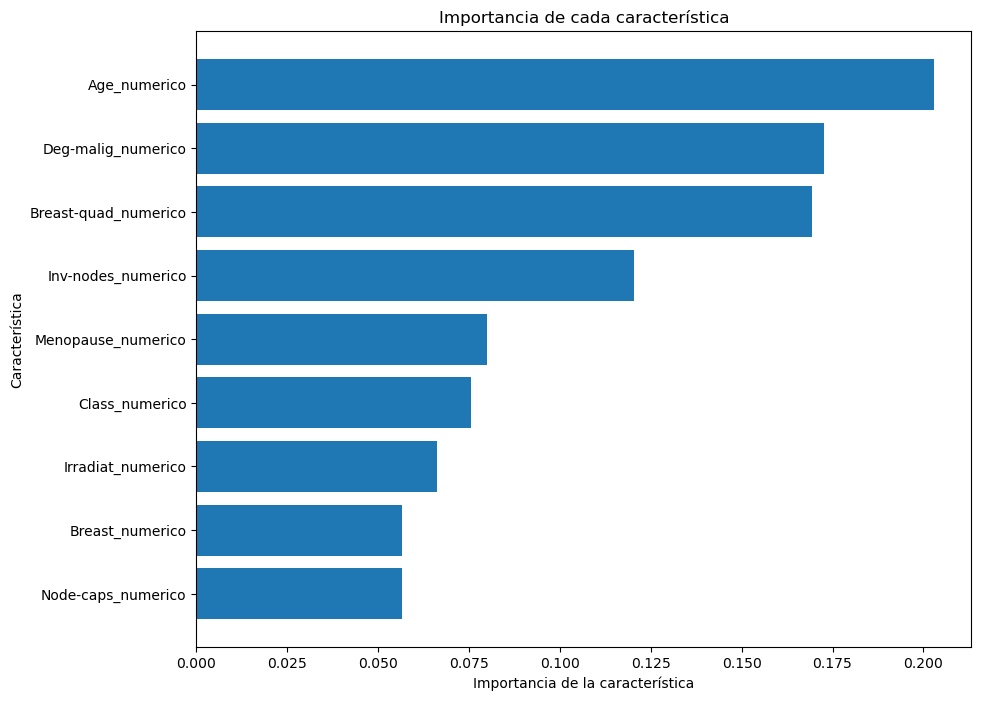

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Define los valores que deseas probar para cada hiperparámetro
n_estimators_values = [50, 100, 150]
max_depth_values = [3, 5, 7]  # Gradient Boosting generalmente tiene menos sobreajuste con árboles más superficiales
learning_rate_values = [0.01, 0.1, 0.5]  # Tasa de aprendizaje
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

best_accuracy = 0
best_params = {}

# Itera sobre todas las combinaciones de hiperparámetros
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for learning_rate in learning_rate_values:
            for min_samples_split in min_samples_split_values:
                for min_samples_leaf in min_samples_leaf_values:
                    # Define el clasificador con los hiperparámetros actuales
                    clf = GradientBoostingClassifier(n_estimators=n_estimators, 
                                                     max_depth=max_depth, 
                                                     learning_rate=learning_rate,
                                                     min_samples_split=min_samples_split, 
                                                     min_samples_leaf=min_samples_leaf,
                                                     random_state=3)
                    # Entrena el clasificador
                    clf.fit(X_train, y_train)

                    # Evalúa el rendimiento en los datos de prueba
                    y_pred = clf.predict(X_test)
                    accuracy = accuracy_score(y_test, y_pred)

                    # Actualiza el mejor rendimiento y los mejores hiperparámetros si es necesario
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {'n_estimators': n_estimators, 
                                       'max_depth': max_depth,
                                       'learning_rate': learning_rate,
                                       'min_samples_split': min_samples_split, 
                                       'min_samples_leaf': min_samples_leaf}

print("Mejores hiperparámetros:", best_params)
print("Mejor precisión con Gradient Boosting:", best_accuracy)
import matplotlib.pyplot as plt

# Entrenar el modelo con los mejores hiperparámetros encontrados
best_clf = GradientBoostingClassifier(n_estimators=best_params['n_estimators'],
                                      max_depth=best_params['max_depth'],
                                      learning_rate=best_params['learning_rate'],
                                      min_samples_split=best_params['min_samples_split'],
                                      min_samples_leaf=best_params['min_samples_leaf'],
                                      random_state=3)

best_clf.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importance = best_clf.feature_importances_

# Obtener nombres de características
feature_names = X_train.columns

# Ordenar índices de importancia de características
sorted_idx = feature_importance.argsort()

# Crear gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importancia de la característica')
plt.ylabel('Característica')
plt.title('Importancia de cada característica')
plt.show()
